DATASET - Android_malware.csv

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 284500, number of used features: 24
[LightGBM] [Info] Start training from score -0.880439
[LightGBM] [Info] Start training from score -1.663325
[LightGBM] [Info] Start training from score -1.111009
[LightGBM] [Info] Start training from score -2.708085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

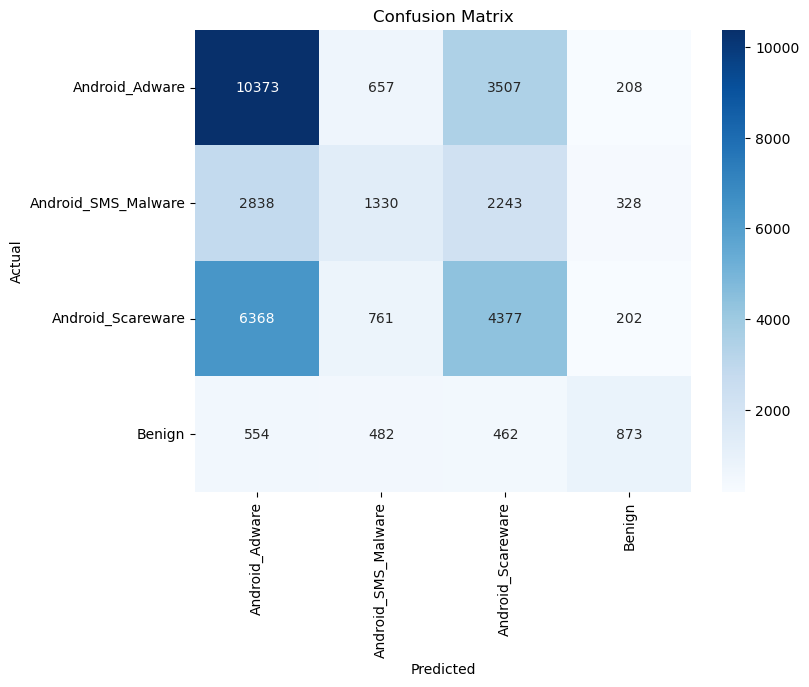

Multi-class ROC-AUC Score: 0.7464


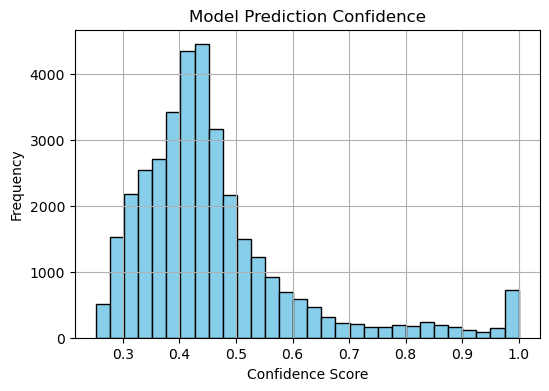

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("Android_malware.csv", low_memory=False)

# 2. Handle missing values
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# 3. Separate features and labels
X = df.drop("Label", axis=1)

# Drop non-numeric columns (e.g., IPs, ports, strings)
X = X.select_dtypes(include=[np.number])

y = df["Label"]

# 4. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 5. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 7. Split into train/val/test (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 8. Set up parameter grid for GridSearchCV
'''param_grid = {
    'num_leaves': [31, 50, 100],  # Number of leaves in the tree
    'max_depth': [-1, 5, 10],  # Maximum depth of tree (-1 means no limit)
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'n_estimators': [100, 200, 500],  # Number of trees
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used for each tree
}'''

param_grid = {
    'num_leaves': [50],  # Number of leaves in the tree
    'max_depth': [5],  # Maximum depth of tree (-1 means no limit)
    'learning_rate': [0.05],  # Learning rate
    'n_estimators': [200],  # Number of trees
    'subsample': [0.8],  # Fraction of samples used for training
    'colsample_bytree': [0.8]  # Fraction of features used for each tree
}

# 9. Initialize LightGBM model
model = LGBMClassifier(random_state=42)

# 10. Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# 11. Fit GridSearchCV
grid_search.fit(X_train, y_train)

# 12. Get best parameters from GridSearchCV
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# 13. Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# 14. Train the best model on the training data
best_model.fit(X_train, y_train)

# 15. Predict on the test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

# 16. Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 17. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 18. ROC-AUC Score (One-vs-Rest)
try:
    roc_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_proba, multi_class="ovr")
    print(f"Multi-class ROC-AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f"ROC-AUC could not be computed: {e}")

# 19. Confidence Histogram
confidences = np.max(y_pred_proba, axis=1)
plt.figure(figsize=(6, 4))
plt.hist(confidences, bins=30, color='skyblue', edgecolor='black')
plt.title("Model Prediction Confidence")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


[LightGBM] [Info] Number of positive: 117954, number of negative: 166546
[LightGBM] [Info] Number of positive: 53915, number of negative: 230585
[LightGBM] [Info] Number of positive: 93665, number of negative: 190835
[LightGBM] [Info] Number of positive: 18966, number of negative: 265534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 284500, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] [

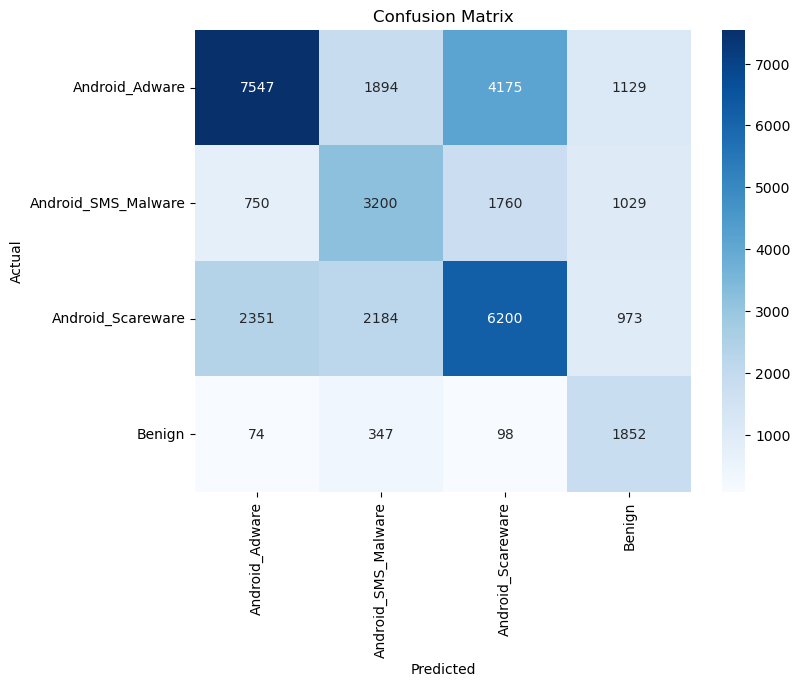

Multi-class ROC-AUC Score: 0.7899


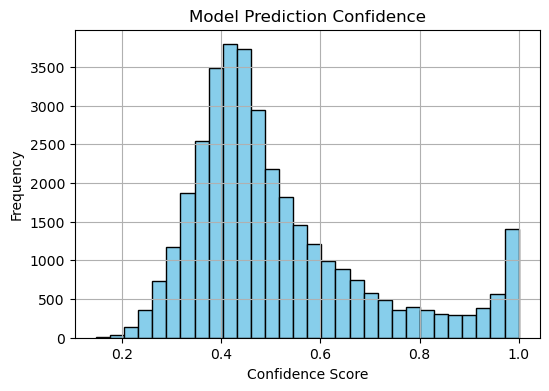

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("Android_malware.csv", low_memory=False)

# 2. Handle missing values
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# 3. Separate features and labels
X = df.drop("Label", axis=1)

# Drop non-numeric columns (e.g., IPs, ports, strings)
X = X.select_dtypes(include=[np.number])

y = df["Label"]

# 4. Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 5. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 7. Split into train/val/test (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 8. Train LightGBM model
'''param_grid = {
    'num_leaves': [31, 50, 100],  # Number of leaves in the tree
    'max_depth': [-1, 5, 10],  # Maximum depth of tree (-1 means no limit)
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'n_estimators': [100, 200, 500],  # Number of trees
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0]  # Fraction of features used for each tree
}'''


model = LGBMClassifier(
    objective='multiclassova',
    class_weight='balanced',
    num_leaves=40,
    max_depth=12,
    learning_rate=0.05,
    n_estimators=3000,
    min_child_samples=10,
    min_split_gain=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    #min_data_in_leaf=10,             # default is 20; lowering helps small splits
    #min_gain_to_split=0.0,           # default is 0.0; ensures splits aren't blocked by gain threshold
    random_state=42)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=100)],
)

# 9. Evaluate model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 11. ROC-AUC Score (One-vs-Rest)
try:
    roc_auc = roc_auc_score(pd.get_dummies(y_test), y_pred_proba, multi_class="ovr")
    print(f"Multi-class ROC-AUC Score: {roc_auc:.4f}")
except Exception as e:
    print(f"ROC-AUC could not be computed: {e}")

# 12. Confidence Histogram
confidences = np.max(y_pred_proba, axis=1)
plt.figure(figsize=(6, 4))
plt.hist(confidences, bins=30, color='skyblue', edgecolor='black')
plt.title("Model Prediction Confidence")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
